# Fantasy Premier League 2021/2022 Season Analysis:

**This notebook covers how to access the Fantasy Premier League API, build a dataframe, and analyze  the data using Jupyter, Python, Pandas, and Matplotlib.**

**About the game**: Each FPL manager is given a starting budget of £100 million and must pick a total of 15 players: two goalkeepers, five defenders, five midfielders and three forwards. You are limited to a maximum of three players from each Premier League team. Players in your team score points based on real-life performances with the biggest contributors being goals, assists and cleansheets.

**Analysis Limits**: The data used in this notebook includes all season totals at the end of Gameweek 38 of the 2021/2022 season. This is more of a season overview analysis than a week-to-week analysis, therefore, form and fixtures were not accounted for. The prices used are provided by the FPL API and have already changed to 2022/2023 prices. I have created a 'price range' category to make the analysis more accurate as price changes generally happen within their price range.

## 4. Machine Learning

### Multiple Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle

In [2]:
#Load data
df1 = pd.read_csv('data/21_22_season_data/fpl_clean.csv')
df2 = pd.read_csv('data/22_23_season_data/fpl_clean.csv')

new_df = df1.append(df2)


In [3]:
#Consider only players who have played atleast 40% of total possible minutes

filt = (new_df['minutes'] > new_df['minutes'].max() * 0.4)
slim_df = new_df.loc[filt]

In [4]:
#Select features
features =  ['points_per_game', 'influence', 'ict_index', 'minutes']
target = 'total_points'

### Check for multicollinearity

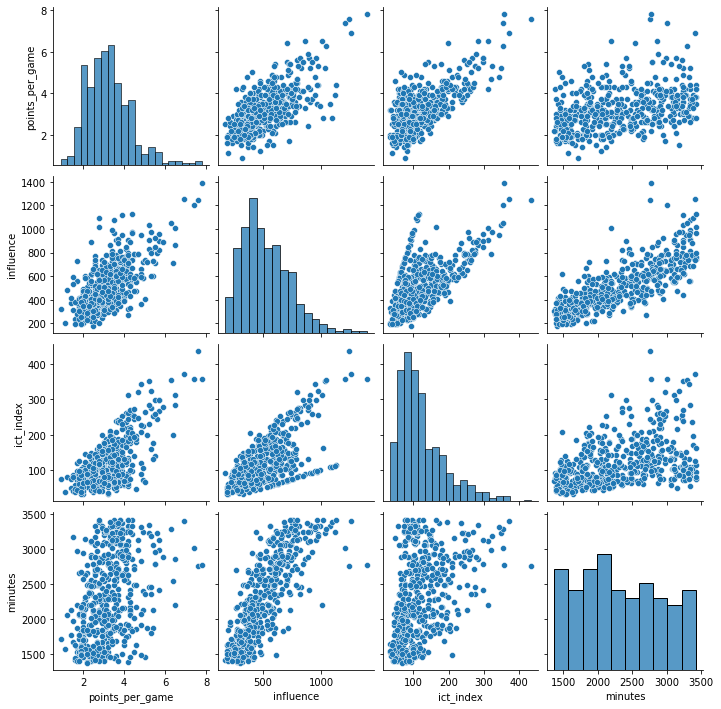

In [5]:

sns.pairplot(slim_df.reset_index()[features])

### Train Model

We split our data into a train set and test set using a 80/20 split. We then use the fit() and predict() methods to train and test our models, respectively.

In [6]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

filt = (df2['minutes'] > df2['minutes'].max() * 0.4)
slim_df2 = df2.loc[filt]
#Create target and feature
X = slim_df2[features]
y = slim_df2[target]

#Split dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit model
mlr = linear_model.LinearRegression()
mlr.fit(x_train,y_train)

#Make estimate
Yhat = mlr.predict(x_test)

### Evaluate Model

Next is to evaluate the models performance. We use a combination of R2, MAE, MSE, RMSE and the Nomalized RMSE by calling methods on the metric object.

In [7]:
from sklearn import metrics

#Evaluation metrics
meanAbErr = metrics.mean_absolute_error(y_test, Yhat)
meanSqErr = metrics.mean_squared_error(y_test, Yhat)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, Yhat))

print('R squared:{:.2f}'.format(mlr.score(X, y)))
print('Mean Absolute Error:', meanAbErr)
print('Mean Squared Error:', meanSqErr)
print('Root Mean Squared Error:', rootMeanSqErr)
print('Normalized RMSE:', rootMeanSqErr / (y.max() - y.min()))

# The coefficient and intercept
intercept = mlr.intercept_
coef = mlr.coef_

print('Intercept:', intercept)
print ('Coefficients:', coef)

R squared:0.94
Mean Absolute Error: 7.737365684565139
Mean Squared Error: 88.82363165388053
Root Mean Squared Error: 9.424628992903674
Normalized RMSE: 0.038156392683820546
Intercept: -43.67632591244738
Coefficients: [ 2.45599776e+01 -5.68816860e-04  1.32418604e-01  2.12832274e-02]


We define a helper function which we will use to make points predictions for our players. We will only use the data from the 2021/2022 season.

In [8]:
#Define points predictor helper function
def predict_player_points(w, b, name, player_features):
    stats = player_features[name]
    stats = list(stats) 
    estimate = round(np.dot(w, stats) + b)
    if estimate < 0:
        estimate = 0
    return estimate

In [9]:
#Create players dictionary
players_dict = dict(zip(df1['web_name'], df1[features].values))

#Add predicted points column
df1['predicted_points'] = df1['web_name'].apply(lambda x: predict_player_points(coef, intercept, x, players_dict))

#Create error column
df1['error'] = df1['total_points'] - df1['predicted_points']

Here we want to get a visual representation of the spread of our errors 

<AxesSubplot:xlabel='error', ylabel='Count'>

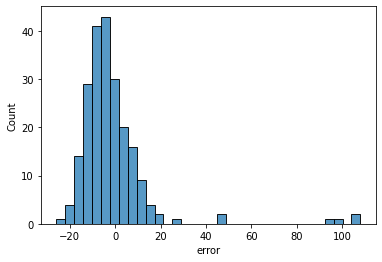

In [10]:
#View distribution of error
filt = (df1['minutes'] > 38 * 0.4 * 90)
slim_df1 = df1.loc[filt]
sns.histplot(data=slim_df1, x='error')

In [11]:
g = df1[df1['position'] == 'GKP'].sort_values(by='predicted_points', ascending=False).head(2)
d = df1[df1['position'] == 'DEF'].sort_values(by='predicted_points', ascending=False).head(5)
m = df1[df1['position'] == 'MID'].sort_values(by='predicted_points', ascending=False).head(5)
f = df1[df1['position'] == 'FWD'].sort_values(by='predicted_points', ascending=False).head(3)

predicted_df = pd.concat([g,d,m,f])
predicted_df[['web_name', 'total_points', 'predicted_points']]

,web_name,total_points,predicted_points


In [12]:
g = df1[df1['position'] == 'GKP'].sort_values(by='total_points', ascending=False).head(2)
d = df1[df1['position'] == 'DEF'].sort_values(by='total_points', ascending=False).head(5)
m = df1[df1['position'] == 'MID'].sort_values(by='total_points', ascending=False).head(5)
f = df1[df1['position'] == 'FWD'].sort_values(by='total_points', ascending=False).head(3)

predicted_df = pd.concat([g,d,m,f])
predicted_df[['web_name', 'total_points', 'predicted_points']]

,web_name,total_points,predicted_points


Store model in pickle file

In [30]:
with open('data/model.pkl', 'wb') as file:
    pickle.dump(mlr, file)